In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [10]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["v6","evtgen_v2_rec_v5", "spice_tau_reco"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/debug_millipede/plots"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [9]:
keys_to_merge = {}

keys_to_merge["evtgen_v2_rec_v5"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["v6"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["spice_tau_reco"] = {
    "NuE" : ["NuE_midE1", "NuE_highE1", "NuE_midE2", "NuE_highE2"],
    "NuMu" : ["NuMu_midE1", "NuMu_highE1","NuMu_midE2", "NuMu_highE2"],
    "NuTau" : ["NuTau_midE1", "NuTau_highE1","NuTau_midE2", "NuTau_highE2"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],

}

In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE1
----- Extracting file

In [12]:
dataset_label_dict = {
    "v6" : "ftp-v3 v6",
    "evtgen_v2_rec_v5" : "ftp-v3 v5",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

In [13]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                 astro_NuE    astro_NuMu   astro_NuTau            conv        prompt
ftp-v3 v6     54.00 ± 1.62  22.24 ± 0.83  36.70 ± 1.34  47.780 ± 4.048  13.35 ± 0.32
ftp-v3 v5     56.92 ± 0.55  20.60 ± 0.25  35.03 ± 0.40  41.074 ± 1.099  13.46 ± 0.10
spice v3.2.1  56.77 ± 0.56  20.42 ± 0.22  34.89 ± 0.43  38.766 ± 0.947  13.41 ± 0.11


Lets see the direction of the MillipedeFit

In [28]:
test_file = simulation_datasets["v6"]["NuTau_midE"]["hdf_file"]

millipede = test_file["HESEMillipedeFit"].iloc[0:1]
monomillipede = test_file["MonopodFit_iMIGRAD_PPB0"].iloc[0:1]
taumillipede = test_file["TaupedeFit_iMIGRAD_PPB0"].iloc[0:1]
SPEmillipede = test_file["SPEFit16"].iloc[0:1]

print("zen millipede", millipede["zenith"][0], millipede["azimuth"][0])
print("zen monomillipede", monomillipede["zenith"][0], monomillipede["azimuth"][0])
print("zen taumillipede", taumillipede["zenith"][0], taumillipede["azimuth"][0])
print("zen millipede", SPEmillipede["zenith"][0], SPEmillipede["azimuth"][0])

zen millipede 1.2381101383128024 5.397895151759927
zen monomillipede 1.2381101383128024 5.397895151759927
zen taumillipede 1.3114113221914596 5.318199207411487
zen millipede 0.34924099438352646 1.3063118217653524


Lets make an angular resolution plot between taupede and millipede for both spice_tau_reco and v5.

In [39]:
base_key = "spice_tau_reco"
alt_key = "v6"
xscale = "log"
yscale = "linear"

/tmp/ipykernel_6476/2123611294.py:59: RuntimeWarning: divide by zero encountered in divide
  ratio = hist2 / hist1
/tmp/ipykernel_6476/2123611294.py:77: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2
/tmp/ipykernel_6476/2123611294.py:59: RuntimeWarning: invalid value encountered in divide
  ratio = hist2 / hist1


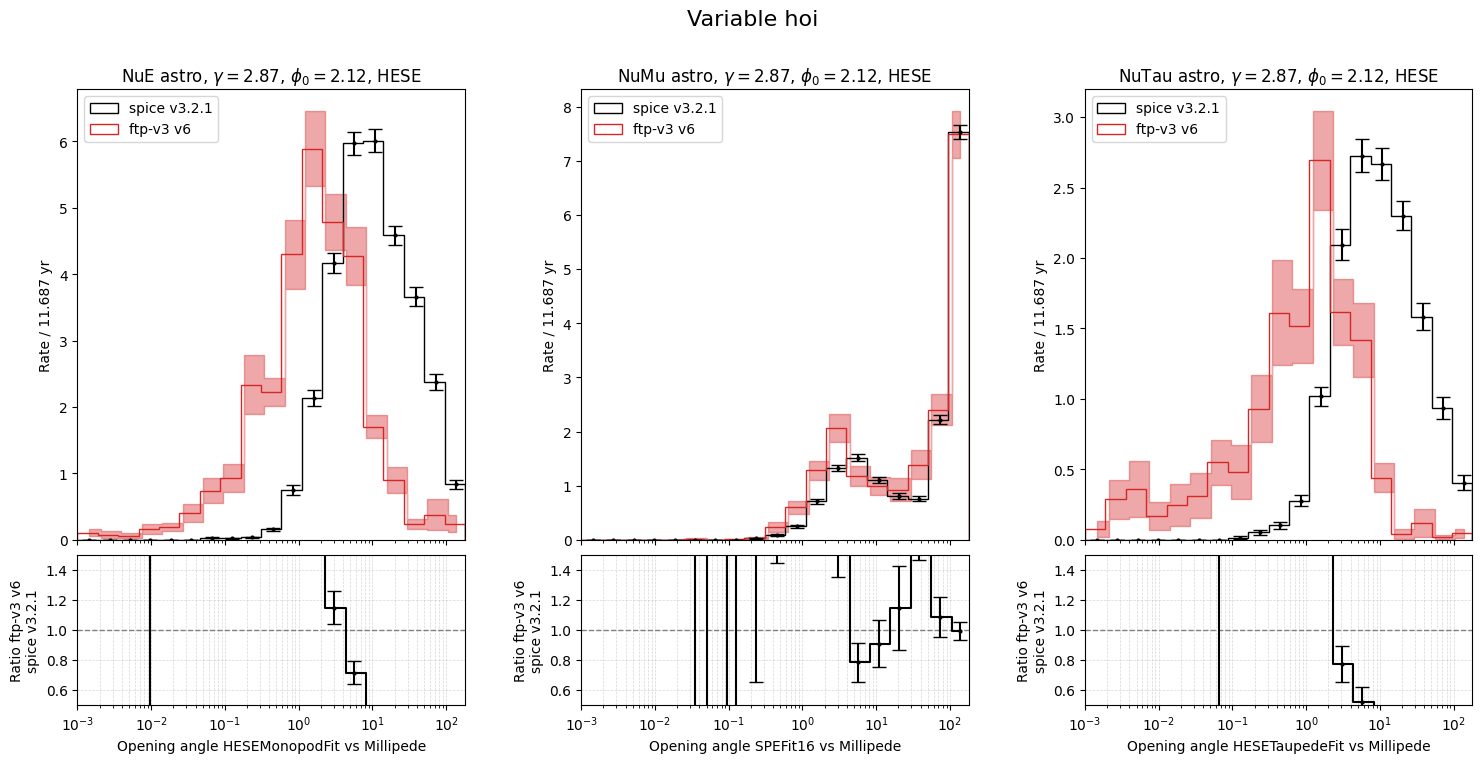

In [42]:
from common import calculator # tianlu
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

bins = np.geomspace( 1e-3,180,20 )

# Compute bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

fig.suptitle(rf"Variable hoi", fontsize=16)

# Create 3 upper and 3 lower subplots
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]        # ax0, ax1, ax2
axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(3)]  # ax0_ratio, etc.

# Now iterate over axes
for ax, ax_ratio, flavor, reco_object1,reco_object2 in zip(axes, axes_ratio, ["NuE", "NuMu", "NuTau"],
                                                           ["HESEMonopodFit", "SPEFit16","HESETaupedeFit"],
                                                           ["MonopodFit_iMIGRAD_PPB0", "SPEFit16","TaupedeFit_iMIGRAD_PPB0"],
                                                           ):
    ax.set_title(rf"{flavor} astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(f"Rate / {livetime_yr} yr") 

    ax_ratio.set_xscale(xscale)
    ax_ratio.set_ylabel(f"Ratio { dataset_label_dict[alt_key]}" + "\n" + f"{dataset_label_dict[base_key]}")
    ax_ratio.set_xlabel(f"Opening angle {reco_object1} vs Millipede")
    ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

    base_milli_zen = simulation_datasets[base_key][flavor]["weighter"].get_column("HESEMillipedeFit", "zenith")
    base_milli_azi = simulation_datasets[base_key][flavor]["weighter"].get_column("HESEMillipedeFit", "azimuth")
    base_taupede_zen = simulation_datasets[base_key][flavor]["weighter"].get_column(reco_object1, "zenith")
    base_taupede_azi = simulation_datasets[base_key][flavor]["weighter"].get_column(reco_object1, "azimuth")
    var1 = np.degrees(calculator.center_angle( base_milli_zen, base_milli_azi, base_taupede_zen, base_taupede_azi))

    alt_milli_zen = simulation_datasets[alt_key][flavor]["weighter"].get_column("HESEMillipedeFit", "zenith")
    alt_milli_azi = simulation_datasets[alt_key][flavor]["weighter"].get_column("HESEMillipedeFit", "azimuth")
    alt_taupede_zen = simulation_datasets[alt_key][flavor]["weighter"].get_column(reco_object2, "zenith")
    alt_taupede_azi = simulation_datasets[alt_key][flavor]["weighter"].get_column(reco_object2, "azimuth")
    var2 = np.degrees(calculator.center_angle( alt_milli_zen, alt_milli_azi, alt_taupede_zen, alt_taupede_azi))


    # Compute histograms
    hist1, _  = np.histogram(var1,weights=simulation_datasets[base_key][flavor]["weights_astro"],bins=bins )
    hist2, _  = np.histogram(var2,weights=simulation_datasets[alt_key][flavor]["weights_astro"],bins=bins )

    # compute errors
    hist1_error, _ = error_cal(bin_edges=bins,weights=simulation_datasets[base_key][flavor]["weights_astro"], data=var1)
    hist2_error, _ = error_cal(bin_edges=bins,weights=simulation_datasets[alt_key] [flavor]["weights_astro"], data=var2)

    # Compute ratios
    ratio = hist2 / hist1

    ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color="black")

    # Upper plot: histograms
    ax.hist(var1, 
            weights=simulation_datasets[base_key][flavor]["weights_astro"], 
            bins=bins, histtype="step", color="black", linestyle="-",label =  dataset_label_dict[base_key])
    ax.hist(var2, 
            weights=simulation_datasets[alt_key][flavor]["weights_astro"], 
            bins=bins, histtype="step", color="C3", linestyle="-",label =  dataset_label_dict[alt_key])

    # Plot the error band
    ax.errorbar(x=bin_centers, y=hist1,yerr=hist1_error, color="black",fmt='o', markersize=2,capsize=5)
    ax.fill_between(bin_centers, hist2 - hist2_error, hist2 + hist2_error,step="mid", alpha=0.4, color="C3")

    # error of the ratio
    ratio_error = ratio * np.sqrt(
            (hist1_error / hist1)**2 + (hist2_error / hist2)**2
    )
    ratio_error[~np.isfinite(ratio_error)] = 0  # Set ratio error to 0 where hist1 or hist2 is 0
    ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_error,fmt='o', color='black', markersize=2, capsize=5)

    # Improve layout
    plt.setp(ax.get_xticklabels(), visible=False)
    ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
    ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_xlim(bins[0], bins[-1])

    ax.legend()

# plt.savefig(f"{plotting_path}/{savename}_flavor.pdf")

plt.show()